In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from tqdm import tqdm
import datashader as ds
import datashader.transfer_functions as tf
from colorcet import fire

In [186]:
# Load in the phishing
phishing_df = pd.read_csv('data/phishing_urls.csv', header = 0).drop(columns = ['FILENAME', 'URLSimilarityIndex'])

# Invert the label column (positive phishing should be 1, not 0)
phishing_df['label'] = phishing_df['label'].map({0: 1, 1: 0})

In [209]:
# EDA

print(phishing_df.columns)

rows, cols = phishing_df.shape

print(f'The phishing urls dataset has {rows} rows and {cols} columns.')

print(phishing_df.dtypes)

# Are there any missing values?
missing_values = phishing_df.isnull().sum()
print(f'There are {missing_values.sum()} missing values in the dataset.')

Index(['URL', 'URLLength', 'Domain', 'DomainLength', 'IsDomainIP', 'TLD',
       'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength',
       'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar',
       'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL',
       'NoOfDigitsInURL', 'DigitRatioInURL', 'NoOfEqualsInURL',
       'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL',
       'SpecialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength',
       'HasTitle', 'Title', 'DomainTitleMatchScore', 'URLTitleMatchScore',
       'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect',
       'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame',
       'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton',
       'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto',
       'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef',
       'NoOfEmptyRef', 'NoOfExternalRef', 'label'],
      dtype='obje

label
0    134850
1    100945
Name: count, dtype: int64


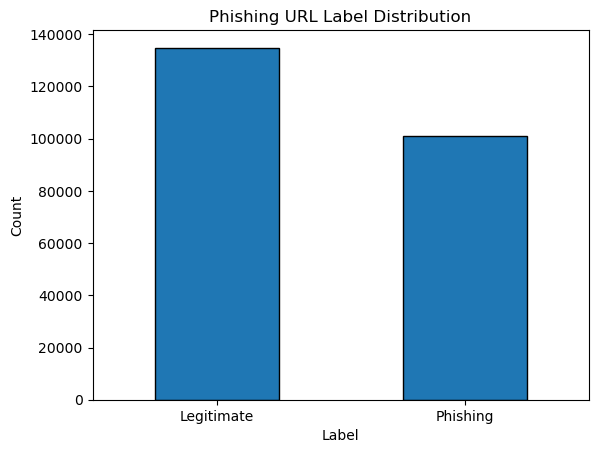

In [188]:
# Value counts of label
print(phishing_df['label'].value_counts()) # 1 is phishing url, 0 is legitimate url

phishing_df['label'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Phishing URL Label Distribution')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.xticks(rotation=0)
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [189]:
categorical_numerical_features = ['IsDomainIP', 'HasObfuscation', 'IsHTTPS', 'HasTitle', 'HasFavicon', 'Robots', 'IsResponsive', 'HasDescription', 'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo']
categorical_nonnumerical_features = []
ss_continuous_features = ['URLLength', 'DomainLength', 'TLDLength', 'NoOfSubDomain', 'NoOfObfuscatedChar', 'NoOfLettersInURL', 'NoOfDigitsInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'LineOfCode', 'LargestLineLength', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'NoOfPopup', 'NoOfiFrame', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef']
minmax_continuous_features = ['CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'ObfuscationRatio', 'LetterRatioInURL', 'DigitRatioInURL', 'SpecialCharRatioInURL', 'DomainTitleMatchScore', 'URLTitleMatchScore']
ordinal_features = []
nonnumeric_features = ['URL', 'Domain', 'TLD', 'Title']
label = 'label'

print(len(minmax_continuous_features))

9


In [190]:
# Calculate label mutual information versus all categorical_numerical_features, ss_continuous_features, and minmax_continuous_features separately
label_mi = {}
for feature in tqdm(categorical_numerical_features + ss_continuous_features + minmax_continuous_features):
    label_mi[feature] = mutual_info_classif(phishing_df[[feature]], phishing_df[label])[0]

# Sort the mutual information values
label_mi = dict(sorted(label_mi.items(), key=lambda item: item[1], reverse=True))

100%|██████████| 49/49 [00:43<00:00,  1.12it/s]


In [191]:
print(pd.Series(label_mi))

LineOfCode                    0.600786
NoOfExternalRef               0.561703
NoOfImage                     0.543664
NoOfSelfRef                   0.527331
NoOfJS                        0.500643
LargestLineLength             0.488090
NoOfCSS                       0.447714
HasSocialNet                  0.417935
LetterRatioInURL              0.381948
HasCopyrightInfo              0.352719
HasDescription                0.306808
IsHTTPS                       0.258173
NoOfOtherSpecialCharsInURL    0.243275
DomainTitleMatchScore         0.218521
HasSubmitButton               0.210021
SpecialCharRatioInURL         0.205830
TLDLegitimateProb             0.198121
URLTitleMatchScore            0.196050
IsResponsive                  0.186911
DigitRatioInURL               0.172232
CharContinuationRate          0.172046
NoOfDigitsInURL               0.171471
NoOfEmptyRef                  0.167885
URLLength                     0.166861
NoOfiFrame                    0.166558
HasHiddenFields          

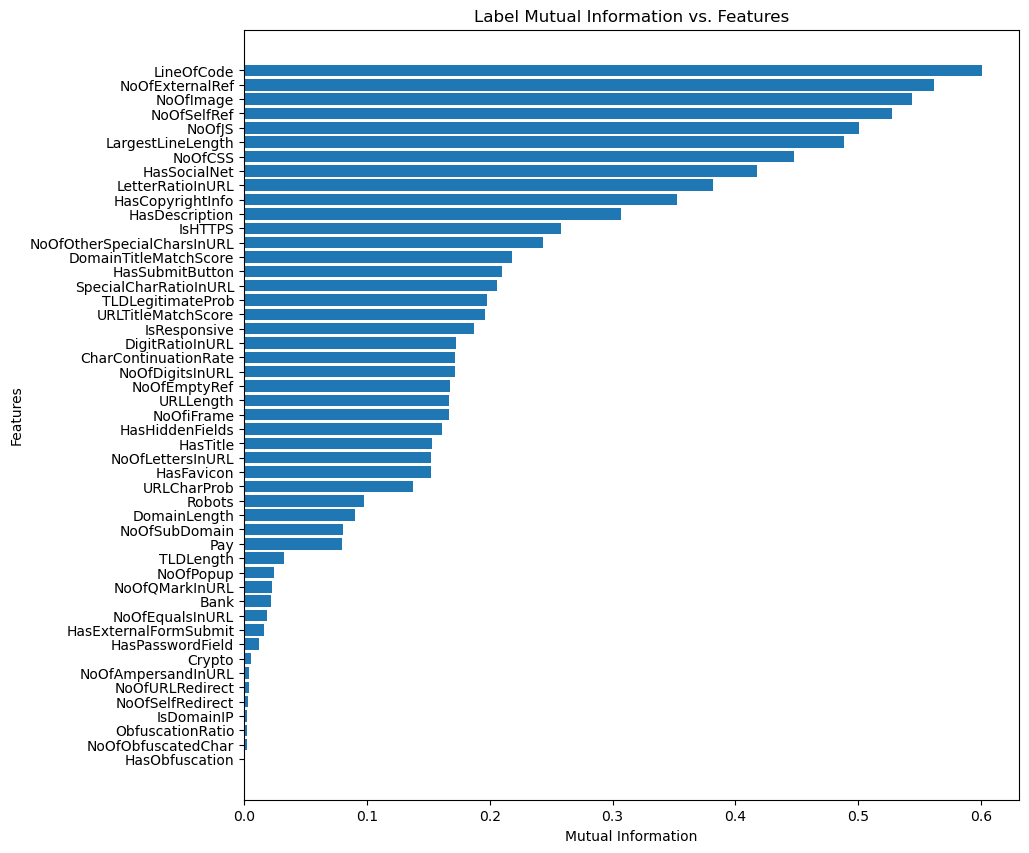

In [192]:
# Plot the mutual information values
plt.figure(figsize=(10, 10))
plt.barh(list(label_mi.keys()), list(label_mi.values()))
plt.yticks(rotation=0)
plt.title('Label Mutual Information vs. Features')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.show()

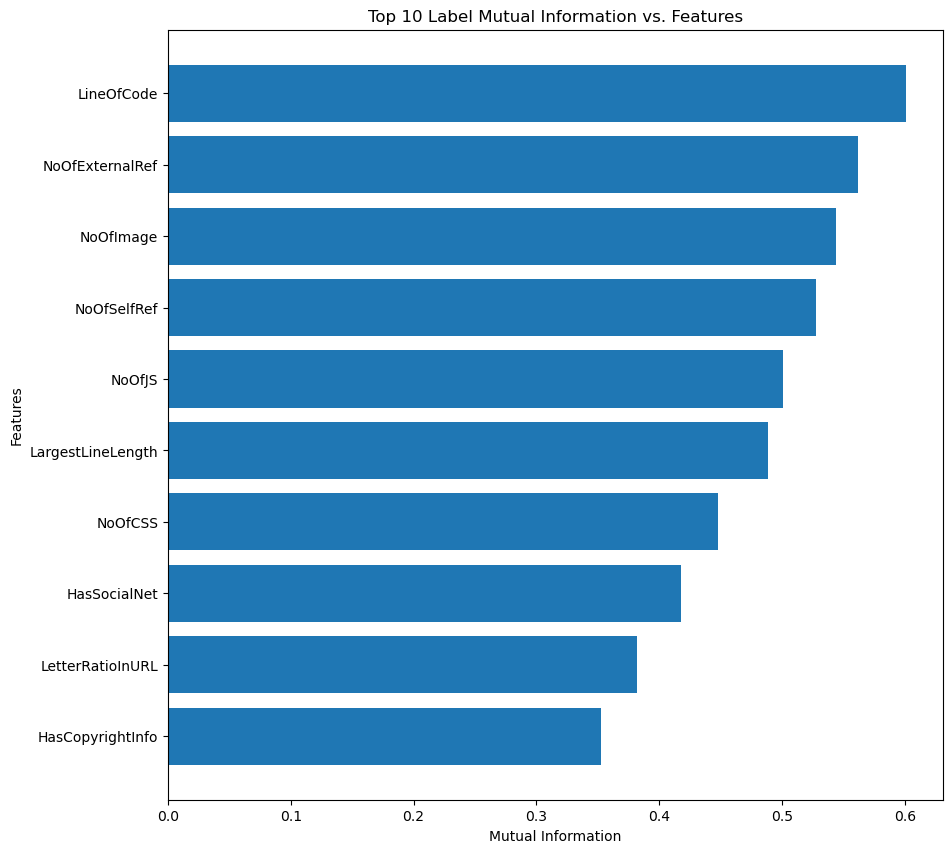

In [207]:
top_10_mi = dict(list(label_mi.items())[:10])

plt.figure(figsize=(10, 10))
plt.barh(list(top_10_mi.keys()), list(top_10_mi.values()))
plt.yticks(rotation=0)
plt.title('Top 10 Label Mutual Information vs. Features')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.show()

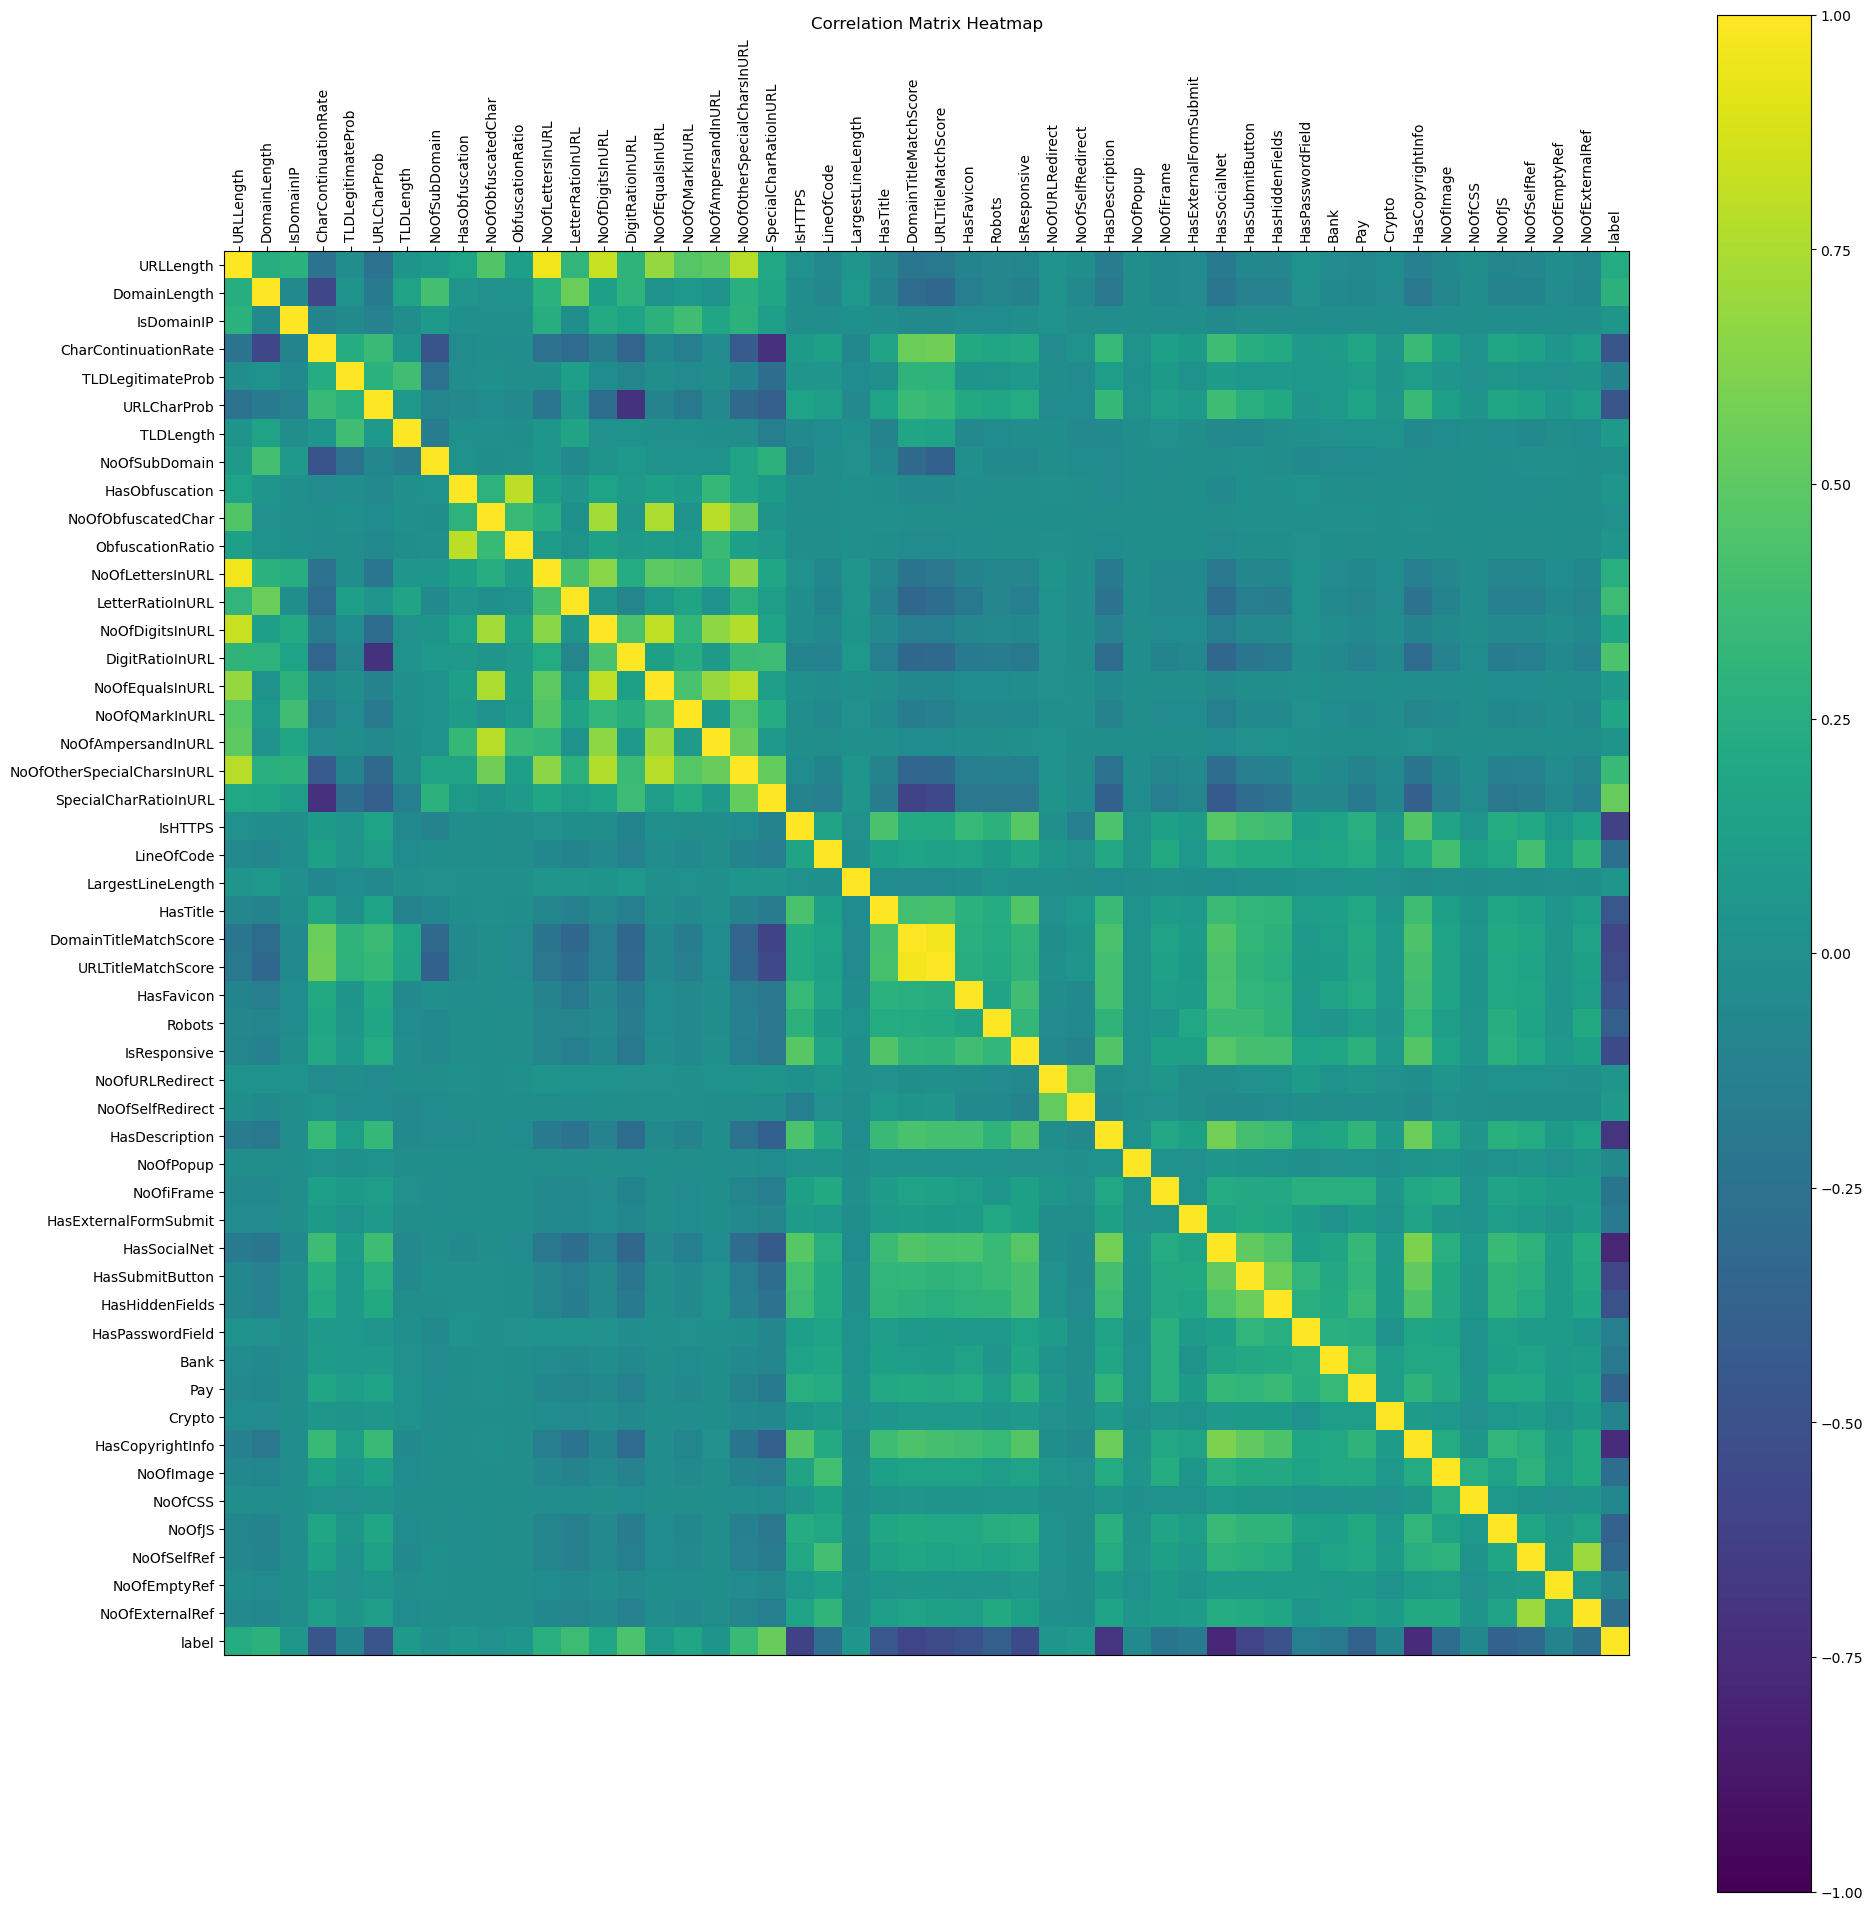

In [193]:
numeric_df = phishing_df.select_dtypes(include='number')

plt.figure(figsize=(20, 20))
plt.imshow(numeric_df.corr(method='pearson'), vmin = -1, vmax = 1)
plt.colorbar()
plt.xticks(range(len(numeric_df.columns)), numeric_df.columns, rotation=90)
plt.yticks(range(len(numeric_df.columns)), numeric_df.columns)
plt.gca().xaxis.tick_top()
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

In [194]:
# Get an ordered list of the numeric features most correlated with label
label_correlations = numeric_df.corr(method='pearson')['label'].sort_values(ascending=False, key=abs)
print(label_correlations)

label                         1.000000
HasSocialNet                 -0.784255
HasCopyrightInfo             -0.743358
HasDescription               -0.690232
IsHTTPS                      -0.609132
DomainTitleMatchScore        -0.584905
HasSubmitButton              -0.578561
IsResponsive                 -0.548608
URLTitleMatchScore           -0.539419
SpecialCharRatioInURL         0.533537
HasHiddenFields              -0.507731
HasFavicon                   -0.493711
URLCharProb                  -0.469749
CharContinuationRate         -0.467735
HasTitle                     -0.459725
DigitRatioInURL               0.432032
Robots                       -0.392620
NoOfJS                       -0.373500
LetterRatioInURL              0.367794
Pay                          -0.359747
NoOfOtherSpecialCharsInURL    0.358891
NoOfSelfRef                  -0.316211
DomainLength                  0.283152
NoOfImage                    -0.274658
LineOfCode                   -0.272257
NoOfExternalRef          

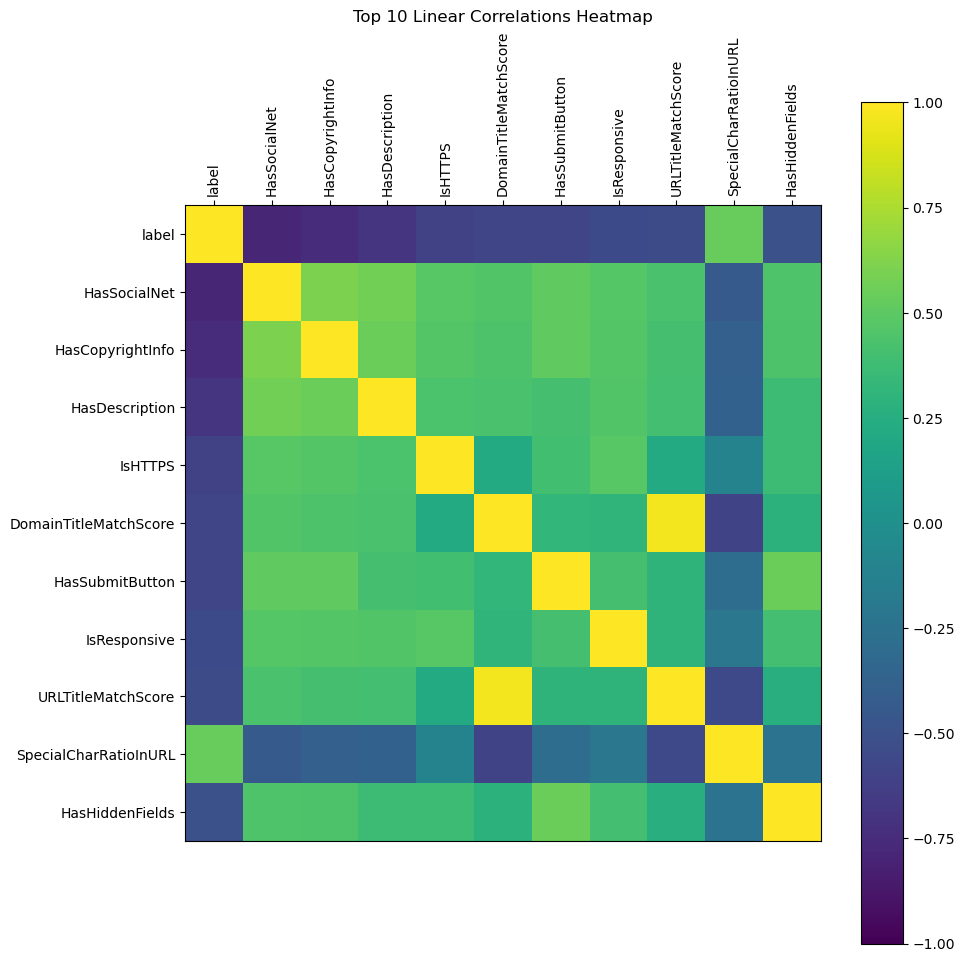

In [206]:
top_ten_linear = label_correlations.head(11)

plt.figure(figsize=(10, 10))
plt.imshow(numeric_df[top_ten_linear.index].corr(method='pearson'), vmin = -1, vmax = 1)
plt.colorbar()
plt.xticks(range(len(top_ten_linear.index)), top_ten_linear.index, rotation=90)
plt.yticks(range(len(top_ten_linear.index)), top_ten_linear.index)
plt.gca().xaxis.tick_top()
plt.title('Top 10 Linear Correlations Heatmap')
plt.tight_layout()
plt.show()


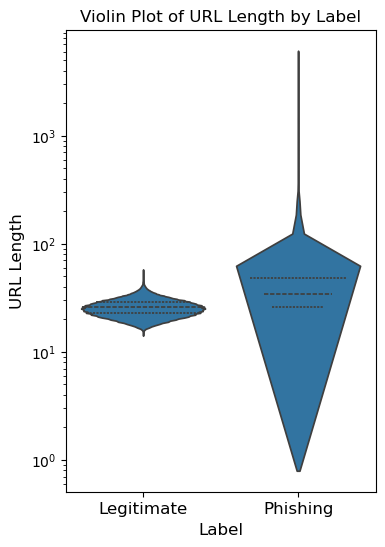

In [195]:
plt.figure(figsize=(4, 6))
sns.violinplot(x='label', y='URLLength', data=phishing_df, density_norm = 'width', inner = 'quartile')
plt.xticks([0, 1], ['Legitimate', 'Phishing'], fontsize = 12)
plt.ylabel('URL Length', fontsize = 12)
plt.xlabel('Label', fontsize = 12)
plt.yscale('log')
plt.title('Violin Plot of URL Length by Label', fontsize = 12)
plt.show()

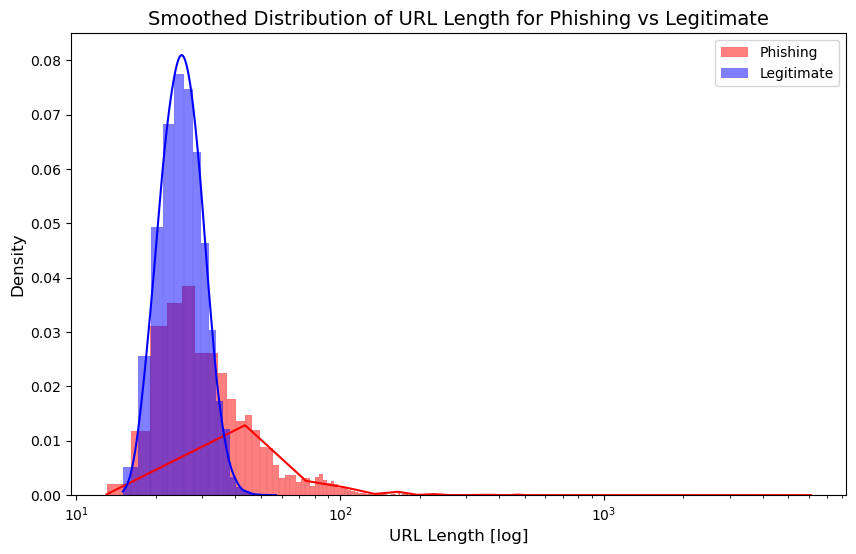

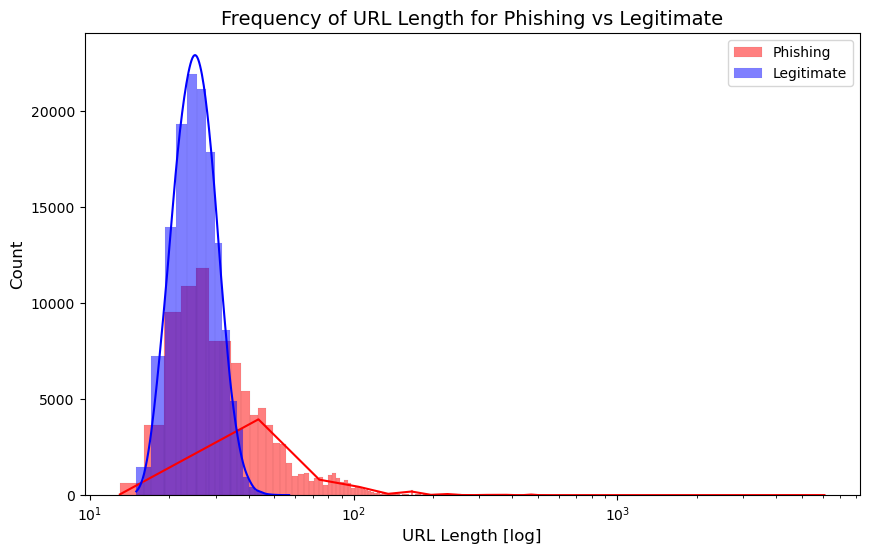

In [196]:
plt.figure(figsize=(10, 6))

sns.histplot(data=phishing_df[phishing_df['label'] == 1], x='URLLength', color='red', kde=True, label='Phishing', stat='density', bins=2000, alpha=0.5, kde_kws={'bw_adjust': 0.1}, common_norm = False)
sns.histplot(data=phishing_df[phishing_df['label'] == 0], x='URLLength', color='blue', kde=True, label='Legitimate', stat='density', bins=20, alpha=0.5, kde_kws={'bw_adjust': 2}, common_norm = False)

plt.xscale('log')
plt.xlabel('URL Length [log]', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Smoothed Distribution of URL Length for Phishing vs Legitimate', fontsize=14)

plt.legend()
plt.show()

# 

plt.figure(figsize=(10, 6))

sns.histplot(data=phishing_df[phishing_df['label'] == 1], 
             x='URLLength', color='red', kde=True, 
             label='Phishing', stat='count', bins=2000, alpha=0.5, 
             kde_kws={'bw_adjust': 0.1}, common_norm=False)

sns.histplot(data=phishing_df[phishing_df['label'] == 0], 
             x='URLLength', color='blue', kde=True, 
             label='Legitimate', stat='count', bins=20, alpha=0.5, 
             kde_kws={'bw_adjust': 2.0}, common_norm=False)

plt.xscale('log')
plt.xlabel('URL Length [log]', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Frequency of URL Length for Phishing vs Legitimate', fontsize=14)

plt.legend()
plt.show()



In [197]:
label_correlations.iloc[1:]

HasSocialNet                 -0.784255
HasCopyrightInfo             -0.743358
HasDescription               -0.690232
IsHTTPS                      -0.609132
DomainTitleMatchScore        -0.584905
HasSubmitButton              -0.578561
IsResponsive                 -0.548608
URLTitleMatchScore           -0.539419
SpecialCharRatioInURL         0.533537
HasHiddenFields              -0.507731
HasFavicon                   -0.493711
URLCharProb                  -0.469749
CharContinuationRate         -0.467735
HasTitle                     -0.459725
DigitRatioInURL               0.432032
Robots                       -0.392620
NoOfJS                       -0.373500
LetterRatioInURL              0.367794
Pay                          -0.359747
NoOfOtherSpecialCharsInURL    0.358891
NoOfSelfRef                  -0.316211
DomainLength                  0.283152
NoOfImage                    -0.274658
LineOfCode                   -0.272257
NoOfExternalRef              -0.258627
NoOfLettersInURL         

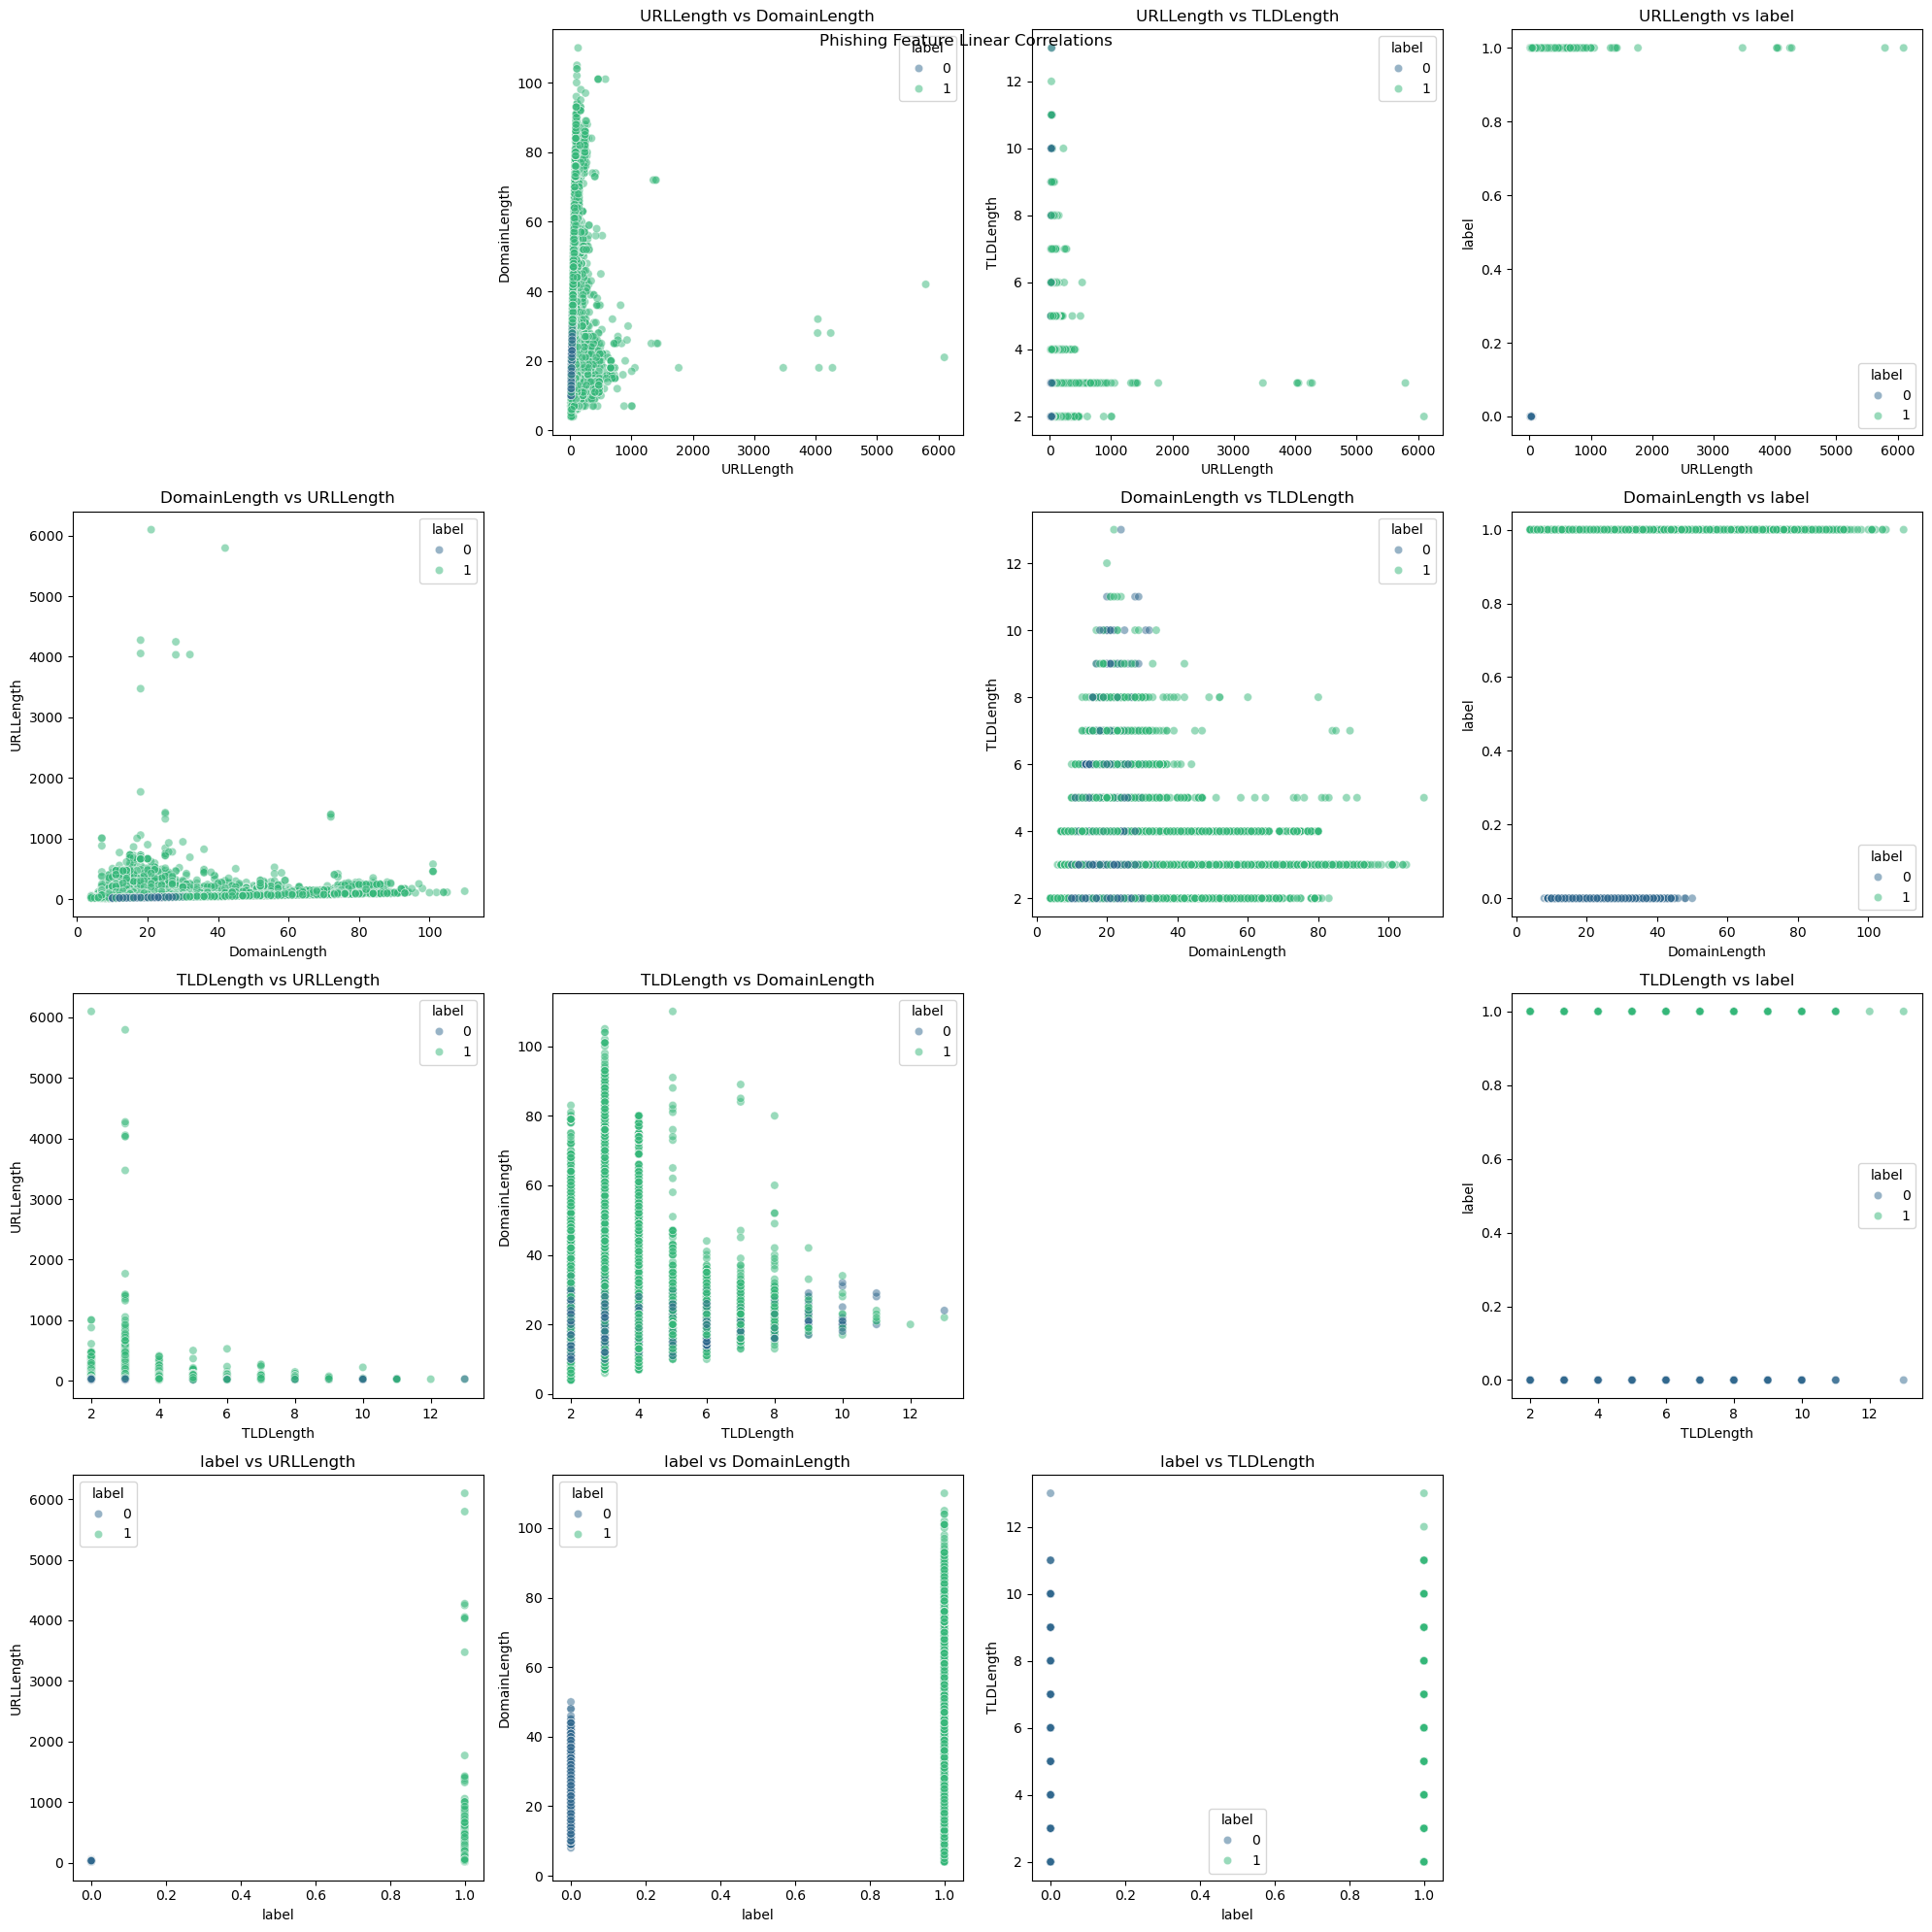

In [198]:
# select the top linear correlated features that are also in the continuous feature array

top_10_linear_continuous = label_correlations[ss_continuous_features + minmax_continuous_features].head(3)

columns = list(top_10_linear_continuous.index) + ['label']
fig, axes = plt.subplots(len(columns), len(columns), figsize=(20, 20))

for i, col1 in enumerate(columns):
    for j, col2 in enumerate(columns):
        if i != j:  # Skip diagonal
            sns.scatterplot(data=phishing_df, x=col1, y=col2, hue='label', ax=axes[i, j], palette='viridis', alpha=0.5)
            axes[i, j].set_title(f'{col1} vs {col2}')
        else:
            axes[i, j].axis('off')  # No plot for the diagonal

plt.tight_layout()
plt.suptitle(f'Phishing Feature Linear Correlations')
plt.show()


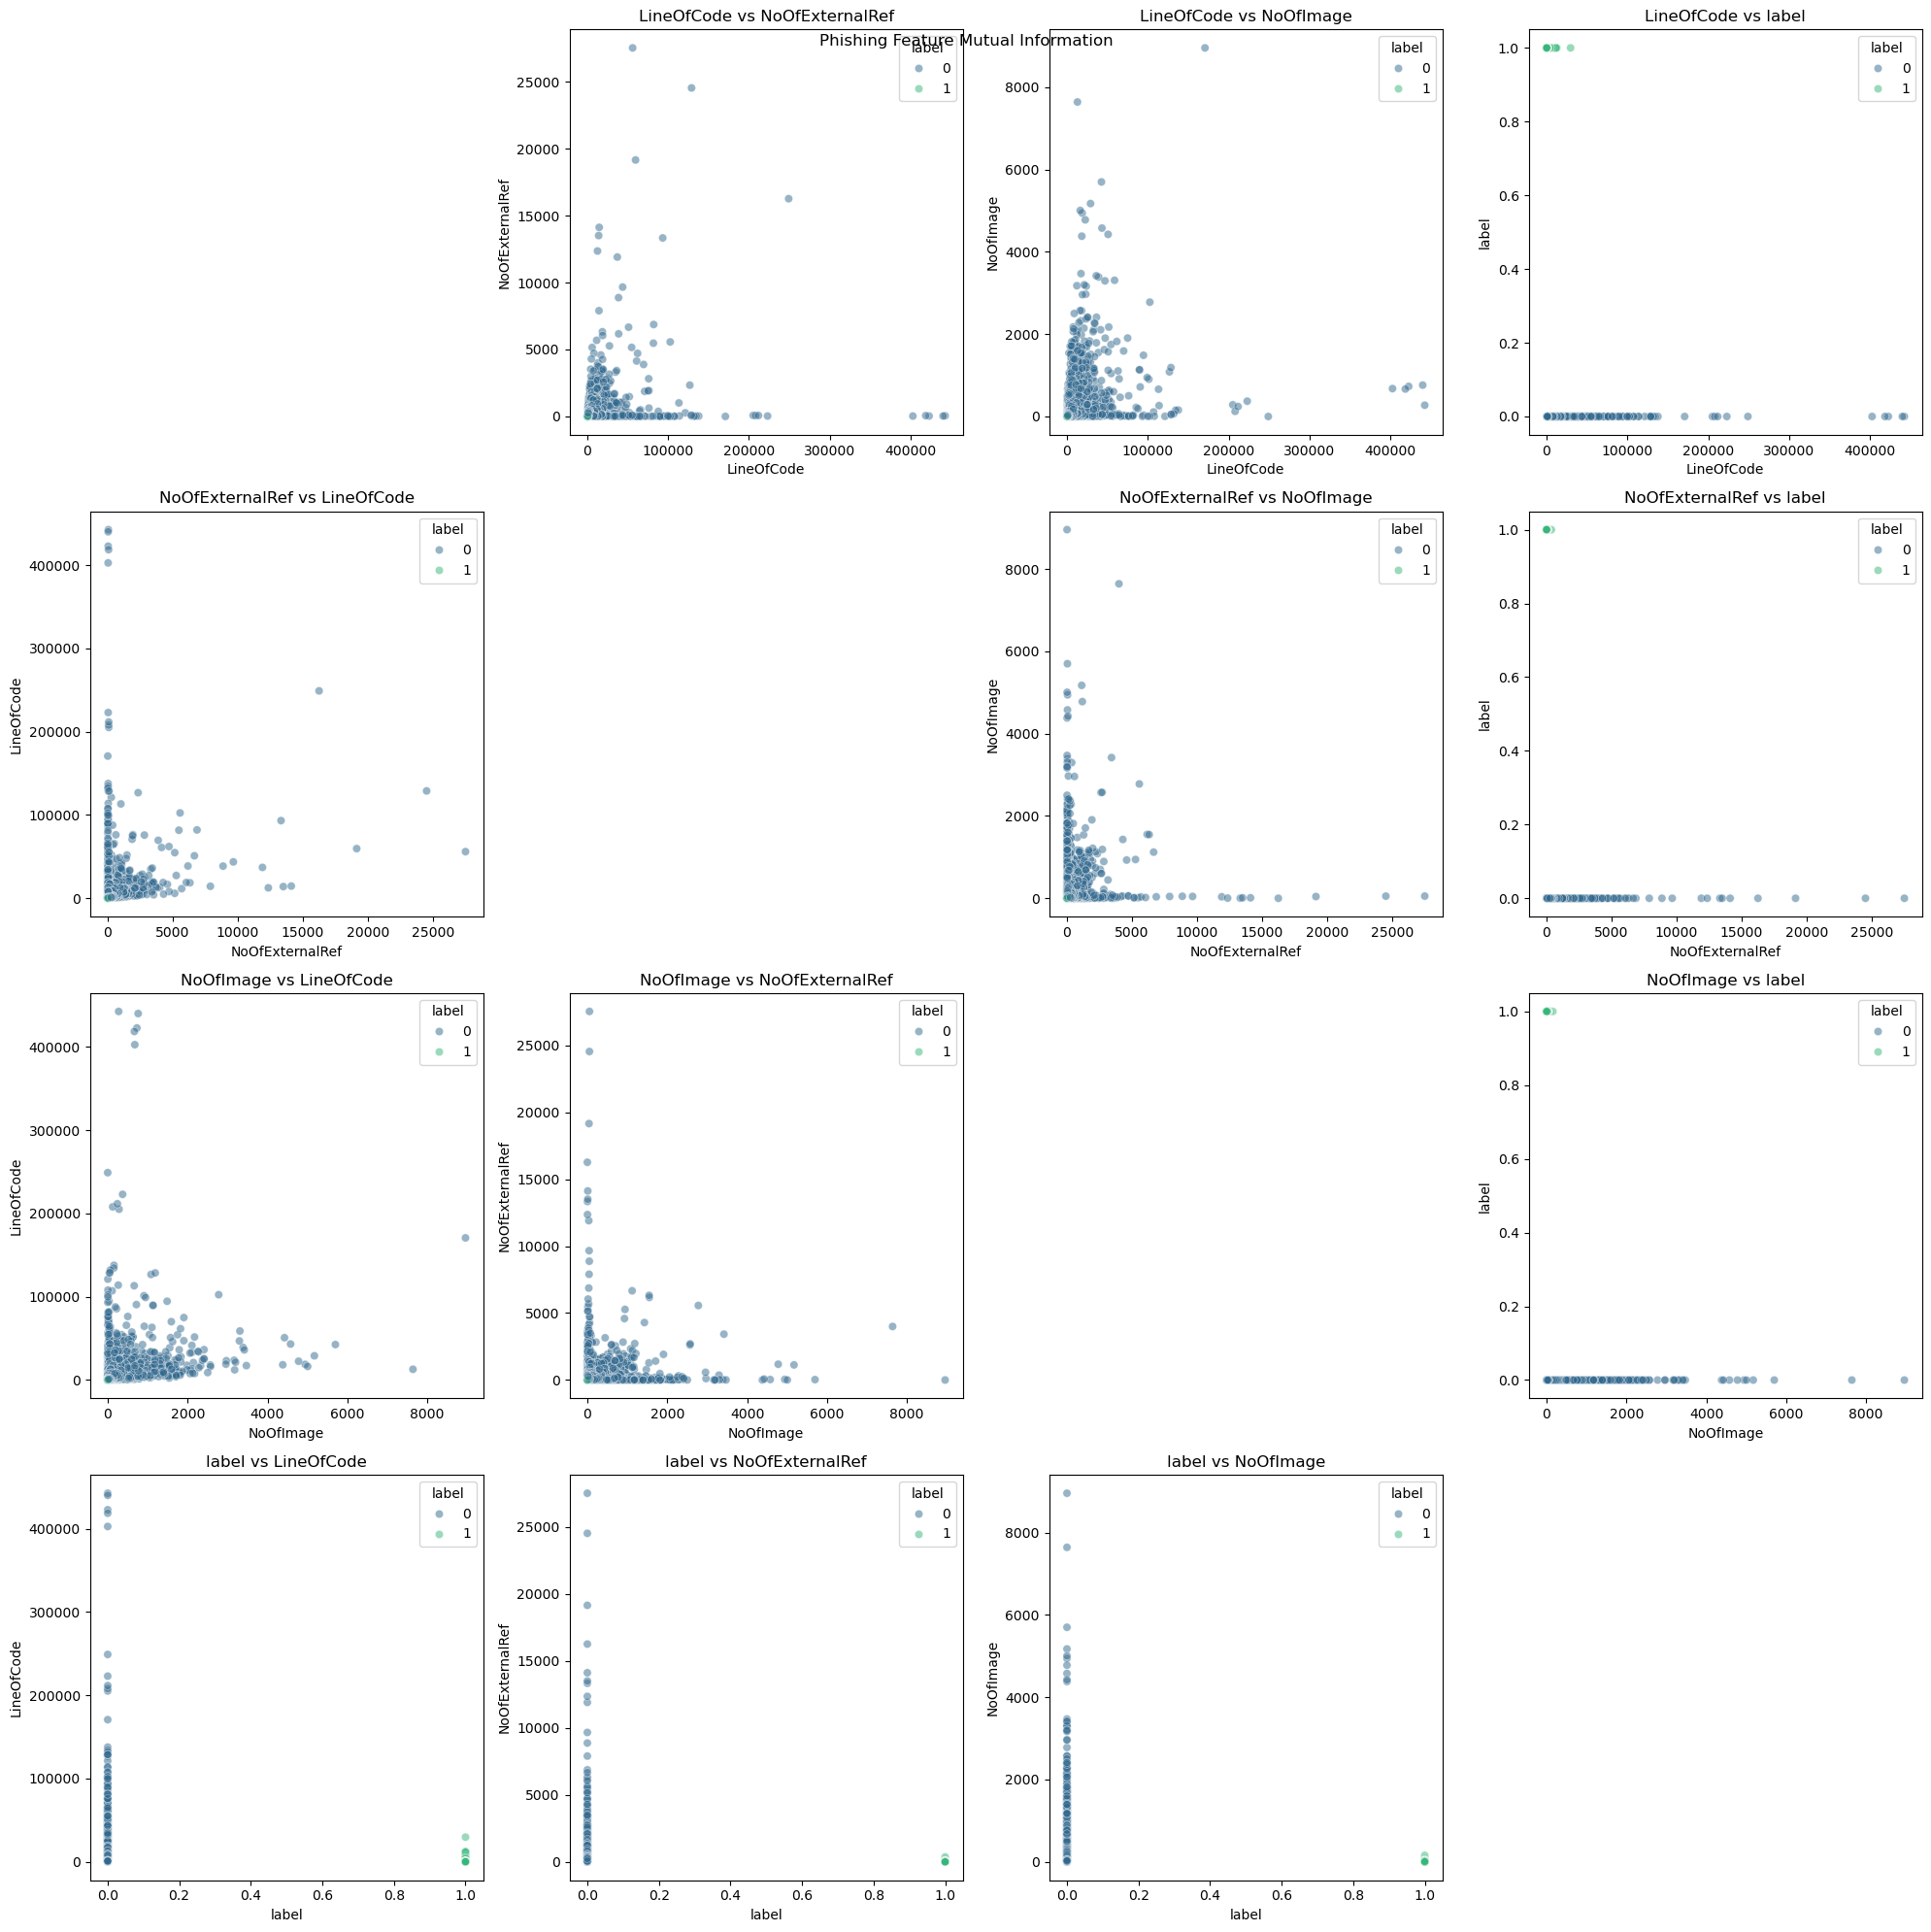

In [199]:
top_3_continuous_mi = dict(list(label_mi.items())[:3])

columns = list(top_3_continuous_mi.keys()) + ['label']
fig, axes = plt.subplots(len(columns), len(columns), figsize=(20, 20))

for i, col1 in enumerate(columns):
    for j, col2 in enumerate(columns):
        if i != j:  # Skip diagonal
            sns.scatterplot(data=phishing_df, x=col1, y=col2, hue='label', ax=axes[i, j], palette='viridis', alpha=0.5)
            axes[i, j].set_title(f'{col1} vs {col2}')
        else:
            axes[i, j].axis('off')  # No plot for the diagonal

plt.tight_layout()
plt.suptitle(f'Phishing Feature Mutual Information')
plt.show()